In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install geopandas
import geopandas as gpd
import os


     |████████████████████████████████| 1.0 MB 5.5 MB/s 
     |████████████████████████████████| 16.7 MB 221 kB/s 
     |████████████████████████████████| 6.3 MB 42.3 MB/s 


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving eGRID2020_subregions.cpg to eGRID2020_subregions.cpg
Saving eGRID2020_subregions.dbf to eGRID2020_subregions.dbf
Saving eGRID2020_subregions.prj to eGRID2020_subregions.prj
Saving eGRID2020_subregions.sbn to eGRID2020_subregions.sbn
Saving eGRID2020_subregions.sbx to eGRID2020_subregions.sbx
Saving eGRID2020_subregions.shp to eGRID2020_subregions.shp
Saving eGRID2020_subregions.shp.xml to eGRID2020_subregions.shp.xml
Saving eGRID2020_subregions.shx to eGRID2020_subregions.shx


# Nova seção

In [ ]:
egrid = pd.read_csv("CO₂ equivalent non-baseload output emission rate (lb_MWh), by eGRID subregion, 2020.csv")
subregions = gpd.read_file(r"eGRID2020_subregions.shp")
vehicles = pd.read_csv("vehicles.csv")
vehicles

,vclass,fuel,energy consumption [MJ/km],ghg emissions [g/MJ],ghg fuel upstream [g/MJ]
0,Medium duty truck,diesel,11.000,69.5,15.34
1,Small diesel vans,diesel,4.900,69.5,15.34
2,Medium duty e-truck,electricity,3.130,177.0,22.00
3,Small electric vans,electricity,1.360,177.0,22.00
4,Electric cargo bicycle,electricity,0.083,177.0,22.00
5,Quad-copter drone,electricity,0.039,177.0,22.00


In [ ]:
vehicles['energy_without_losses_[MJ/km]'] = vehicles['energy consumption [MJ/km]'].copy()
vehicles.loc[2:,'energy consumption [MJ/km]'] = vehicles.loc[2:,'energy consumption [MJ/km]']/((0.88)*(1-6.5/100))
vehicles[['energy_without_losses_[MJ/km]','energy consumption [MJ/km]']]

,energy_without_losses_[MJ/km],energy consumption [MJ/km]
0,11.000,11.000000
1,4.900,4.900000
2,3.130,3.804084
3,1.360,1.652893
4,0.083,0.100875
5,0.039,0.047399


In [ ]:
vclass = ["Medium duty truck", 'Small diesel van', 'Medium duty electric truck', 
          'Small electric van', 'Electric cargo bicycle', 
          'Quad-copter drone']

In [ ]:
unit_dict = {'name': 'str', 'consumption':'MJ/km', 'upstream': "gCO2e/km", 
             'stop_km':"stop/km", 'pack_stop':'package/stop','pack_km':'package/km', 'pack_km_low': 'package/km', 'pack_km_high':'package/km',
            'energy_pack':'MJ/package','energy_pack_upper':'MJ/package','energy_pack_lower':'MJ/package',
            'fuel_emissions':'gCO2e/km', 'battery': 'gCO2e/km', 'total_ghg':"gCO2e/km", 'upstream_pack':'gCO2e/package',
            'battery_pack':'gCO2e/package','fuel_pack':'gCO2e/package','ghg_pack':'gCO2e/package',
             "energy_pack_to_drone":'package/km',"ghg_pack_to_drone":'package/km', "energy_drone_equivalent": "MJ/km"}

In [ ]:
class Vehicle: 
    def __init__(self, name, e_consumption, ghg_upstream, stop_km, pack_stop, pack_km_low, pack_km_high):
        self.name = name
        self.consumption = e_consumption
        self.upstream = ghg_upstream*e_consumption
        self.stop_km = stop_km
        self.pack_stop = pack_stop
        self.pack_km = pack_stop*stop_km
        self.energy_pack = e_consumption/self.pack_km
        self.pack_km_low = pack_km_low
        self.pack_km_high = pack_km_high
        self.energy_pack_upper = e_consumption/pack_km_low   # upper limit
        self.energy_pack_lower = e_consumption/pack_km_high   # lower limit
    
    def set_electric_emissions(self, egrid_df): 
        self.fuel_emissions = {}
        for i in range(len(egrid_df)):
            self.fuel_emissions[egrid_df.loc[i,'Region']] = egrid_df.loc[i,'g/MJ']*self.consumption
            
    def set_diesel_emissions(self, egrid_df, diesel_ghg):
        self.fuel_emissions = {}
        for i in range(len(egrid_df)):
            self.fuel_emissions[egrid_df.loc[i,'Region']] = diesel_ghg*self.consumption
            
    def set_battery_emissions(self, battery_emission):
        self.battery = battery_emission
    
    def compute_ghg_total(self):
        self.total_ghg = {}
        for i in range(len(self.fuel_emissions)):
            region = list(self.fuel_emissions.keys())[i]
            self.total_ghg[region] = self.fuel_emissions[region] + self.upstream + self.battery
    
    def compute_ghg_pack(self):
        self.ghg_pack = {}
        self.fuel_pack = {}
        self.upstream_pack = self.upstream/self.pack_km
        self.battery_pack = self.battery/self.pack_km
        
        for i in range(len(self.fuel_emissions)):
            region = list(self.fuel_emissions.keys())[i]
            self.fuel_pack[region] = self.fuel_emissions[region]/self.pack_km
            self.ghg_pack[region] = self.total_ghg[region]/self.pack_km
    
    def compute_pack_to_drone(self, energy_pack_drone, ghg_pack_drone):
        self.energy_pack_to_drone = self.consumption/energy_pack_drone
        self.ghg_pack_to_drone = {}
        for i in range(len(self.fuel_emissions)):
            region = list(self.fuel_emissions.keys())[i]
            self.ghg_pack_to_drone[region] = self.total_ghg[region]/ghg_pack_drone[region]
    
    def compute_energy_drone_equivalent(self, package_km_drone):
        self.energy_drone_equivalent = self.energy_pack*package_km_drone  
    
            

In [ ]:
# Assumptions
# Trucks have on average 0.7 stops/km @FleetDNA and deliver 3 packages per stop on average
# Vans have on average 1.74 stops/km @FleetDNA and deliver 2 packages per stop on average

diesel_ghg = 69.5 #greet 
stop_km = np.array([0.7, 1.74, 0.7, 1.74, 1, 0.25]) # fleet DNA
battery = np.array([0, 0, 24.5, 14.1, 1.3, 0.76]) # greet  

pack_stop = np.array([3, 2, 3, 2, 1, 1]) # our assumptions
pack_km_low = np.array([1.5, 1.5, 1.5, 1.5, 0.25, 0.125]) # our assumptions >>> fewer packages per km
pack_km_high = np.array([5, 5, 5, 5, 3, 0.5]) # our assumptions >>> more packages per km

v = []
for i in range(len(vclass)):
    v.append(Vehicle(vclass[i], vehicles.loc[i,'energy consumption [MJ/km]'], 
                     vehicles.loc[i,'ghg fuel upstream [g/MJ]'], stop_km[i], pack_stop[i],
                     pack_km_low[i], pack_km_high[i]))
    v[i].set_battery_emissions(battery[i])
    if i < 2:
        v[i].set_diesel_emissions(egrid, diesel_ghg)
    else:
        v[i].set_electric_emissions(egrid)
    v[i].compute_ghg_total()
    v[i].compute_ghg_pack()
for i in range(len(vclass)):
    v[i].compute_pack_to_drone(v[5].energy_pack, v[5].ghg_pack)
    v[i].compute_energy_drone_equivalent(v[5].pack_km)
        

In [ ]:
overview_df = pd.DataFrame()
name = []
consumption = []
upstream = [] 
stop_km = []
pack_stop = []
pack_km = []
energy_pack = []
battery = []
pack_km_low = []
pack_km_high = []
energy_pack_low = []
energy_pack_high = []

for i in range(len(vehicles)):
  name.append(v[i].name)
  consumption.append(v[i].consumption)
  upstream.append(v[i].upstream)
  stop_km.append(v[i].stop_km)
  pack_stop.append(v[i].pack_stop)
  pack_km.append(v[i].pack_km)
  energy_pack.append(v[i].energy_pack)
  pack_km_low.append(v[i].pack_km_low)
  pack_km_high.append(v[i].pack_km_high)
  battery.append(v[i].battery)
  energy_pack_low.append(v[i].energy_pack_lower)
  energy_pack_high.append(v[i].energy_pack_upper)

overview_df = pd.DataFrame({"vehicle_class": name, 'consumption': consumption, 'upstream_emissions': 
                            upstream, 'battery_emissions':battery,'stop_km':stop_km, 
                            "package_stop":pack_stop,'package_km':pack_km, 'package_km_low':pack_km_low,
                            'package_km_high':pack_km_high, "energy_pack":energy_pack,
                            "energy_package_low":energy_pack_low,"energy_package_high":energy_pack_high})


overview_df.to_csv("base_case.csv", index=False)
overview_df

,vehicle_class,consumption,upstream_emissions,battery_emissions,stop_km,package_stop,package_km,package_km_low,package_km_high,energy_pack,energy_package_low,energy_package_high
0,Medium duty truck,11.000000,168.740000,0.00,0.70,3,2.10,1.500,5.0,5.238095,2.200000,7.333333
1,Small diesel van,4.900000,75.166000,0.00,1.74,2,3.48,1.500,5.0,1.408046,0.980000,3.266667
2,Medium duty electric truck,3.804084,83.689840,24.50,0.70,3,2.10,1.500,5.0,1.811468,0.760817,2.536056
3,Small electric van,1.652893,36.363636,14.10,1.74,2,3.48,1.500,5.0,0.474969,0.330579,1.101928
4,Electric cargo bicycle,0.100875,2.219251,1.30,1.00,1,1.00,0.250,3.0,0.100875,0.033625,0.403500
5,Quad-copter drone,0.047399,1.042781,0.76,0.25,1,0.25,0.125,0.5,0.189596,0.094798,0.379193


In [ ]:
for key in unit_dict.keys():
  print(key,":",unit_dict[key])

name : str
consumption : MJ/km
upstream : gCO2e/km
stop_km : stop/km
pack_stop : package/stop
pack_km : package/km
pack_km_low : package/km
pack_km_high : package/km
energy_pack : MJ/package
energy_pack_upper : MJ/package
energy_pack_lower : MJ/package
fuel_emissions : gCO2e/km
battery : gCO2e/km
total_ghg : gCO2e/km
upstream_pack : gCO2e/package
battery_pack : gCO2e/package
fuel_pack : gCO2e/package
ghg_pack : gCO2e/package
energy_pack_to_drone : package/km
ghg_pack_to_drone : package/km
energy_drone_equivalent : MJ/km


In [ ]:
total_ghg_df = pd.DataFrame({"subregion":v[0].total_ghg.keys()})
ghg_pack_df = pd.DataFrame({"subregion":v[0].total_ghg.keys()})

for i in range(len(vehicles)):
  total_ghg_df[v[i].name] = v[i].total_ghg.values()
  ghg_pack_df[v[i].name] = v[i].ghg_pack.values()


total_ghg_df.to_csv('ghg_km.csv', index=False)
ghg_pack_df.to_csv("ghg_pack.csv", index=False)


In [ ]:
max = 0
max_region = 0
min = 1000
min_region = 0
vehicle = 4
for key in v[vehicle].ghg_pack.keys():
  if max < v[vehicle].ghg_pack[key]:
    max = v[vehicle].ghg_pack[key]
    max_region = key
  if min > v[vehicle].ghg_pack[key]:
    min = v[vehicle].ghg_pack[key]
    min_region = key
print(v[vehicle].name,max_region, max, min_region, min)
v[vehicle].ghg_pack

Electric cargo bicycle SPNO 28.734305476665043 NYUP 14.710562924039863


{'AKGD': 20.33983675899368,
 'AKMS': 22.87447163308216,
 'AZNM': 20.99059047143899,
 'CAMX': 16.35536835573651,
 'ERCT': 20.07127374574623,
 'FRCC': 16.41218220879922,
 'HIMS': 23.24318971135148,
 'HIOA': 25.965297577175498,
 'MROE': 24.344259913709283,
 'MROW': 26.683414474963534,
 'NEWE': 14.79225030748663,
 'NWPP': 24.666205060889645,
 'NYCW': 15.86604478111327,
 'NYLI': 19.567575121900823,
 'NYUP': 14.710562924039863,
 'PRMS': 24.856982659090907,
 'RFCE': 19.267618337141467,
 'RFCM': 25.59073289134662,
 'RFCW': 26.67909305797277,
 'RMPA': 24.627566553475933,
 'SPNO': 28.734305476665043,
 'SPSO': 22.849305766771995,
 'SRMV': 18.021907954788528,
 'SRMW': 27.40915738612056,
 'SRSO': 20.591622524671852,
 'SRTV': 22.85070387493923,
 'SRVC': 20.439610516285853,
 'US': 21.40023485306271}

In [ ]:
for i in range(6):
    print(v[i].name, round(v[i].energy_drone_equivalent/v[5].energy_drone_equivalent,2))

Medium duty truck 27.63
Small diesel van 7.43
Medium duty electric truck 9.55
Small electric van 2.51
Electric cargo bicycle 0.53
Quad-copter drone 1.0


In [ ]:
for i in range(6):
    print(v[i].name, round(v[i].energy_drone_equivalent,2))

Medium duty truck 1.31
Small diesel van 0.35
Medium duty electric truck 0.45
Small electric van 0.12
Electric cargo bicycle 0.03
Quad-copter drone 0.05


In [ ]:
for i in range(6):
    print(v[i].name, round(v[i].energy_pack_to_drone,2))

Medium duty truck 58.02
Small diesel van 25.84
Medium duty electric truck 20.06
Small electric van 8.72
Electric cargo bicycle 0.53
Quad-copter drone 0.25


In [ ]:
regions = egrid.Region.copy()
ghg_total_EVs = pd.DataFrame({"region":regions})
for i in range(2,len(v)):
  ghg_total_EVs[v[i].name] = v[i].total_ghg.values()
ghg_total_EVs.to_csv("ghg_total_EVs.csv", index=False)

In [ ]:
vehicles

,vclass,fuel,energy consumption [MJ/km],ghg emissions [g/MJ],ghg fuel upstream [g/MJ],energy_without_losses_[MJ/km]
0,Medium duty truck,diesel,11.000000,69.5,15.34,11.000
1,Small diesel vans,diesel,4.900000,69.5,15.34,4.900
2,Medium duty e-truck,electricity,3.804084,177.0,22.00,3.130
3,Small electric vans,electricity,1.652893,177.0,22.00,1.360
4,Electric cargo bicycle,electricity,0.100875,177.0,22.00,0.083
5,Quad-copter drone,electricity,0.047399,177.0,22.00,0.039


In [ ]:
regions = egrid.Region.copy()
ghg_packs_to_drone = pd.DataFrame({"region":regions})
for i in range(len(v)):
    ghg_packs_to_drone[v[i].name] = v[i].ghg_pack_to_drone.values()
ghg_packs_to_drone['drone_emissions'] = v[5].ghg_pack.values()
ghg_packs_to_drone['drone_emissions_km'] = v[5].total_ghg.values()
    

In [ ]:
subregions.rename(columns={"ZipSubregi":"region"}, inplace=True)


In [ ]:
df = pd.merge(subregions, ghg_packs_to_drone, on='region', how='outer')

In [ ]:
df_main = df.copy()
df_main.drop([0,1,6,7,26],inplace=True)

In [ ]:
print(v[0].__dict__)

{'name': 'Medium duty truck', 'consumption': 11.0, 'upstream': 168.74, 'stop_km': 0.7, 'pack_stop': 3, 'pack_km': 2.0999999999999996, 'energy_pack': 5.238095238095239, 'pack_km_low': 1.5, 'pack_km_high': 5.0, 'energy_pack_upper': 7.333333333333333, 'energy_pack_lower': 2.2, 'battery': 0.0, 'fuel_emissions': {'SPNO': 764.5, 'SRMW': 764.5, 'MROW': 764.5, 'RFCW': 764.5, 'HIOA': 764.5, 'RFCM': 764.5, 'PRMS': 764.5, 'NWPP': 764.5, 'RMPA': 764.5, 'MROE': 764.5, 'HIMS': 764.5, 'AKMS': 764.5, 'SRTV': 764.5, 'SPSO': 764.5, 'AZNM': 764.5, 'SRSO': 764.5, 'SRVC': 764.5, 'AKGD': 764.5, 'ERCT': 764.5, 'NYLI': 764.5, 'RFCE': 764.5, 'SRMV': 764.5, 'FRCC': 764.5, 'CAMX': 764.5, 'NYCW': 764.5, 'NEWE': 764.5, 'NYUP': 764.5, 'US': 764.5}, 'total_ghg': {'SPNO': 933.24, 'SRMW': 933.24, 'MROW': 933.24, 'RFCW': 933.24, 'HIOA': 933.24, 'RFCM': 933.24, 'PRMS': 933.24, 'NWPP': 933.24, 'RMPA': 933.24, 'MROE': 933.24, 'HIMS': 933.24, 'AKMS': 933.24, 'SRTV': 933.24, 'SPSO': 933.24, 'AZNM': 933.24, 'SRSO': 933.24, '

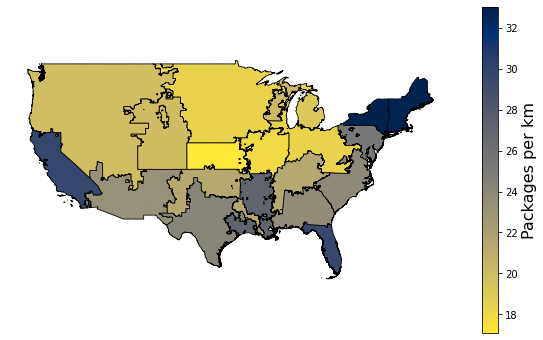

In [ ]:
fig, ax = plt.subplots(1, figsize=(10, 6))
v_compare = 'Medium duty truck'
vmin = df[v_compare].min()
vmax = df[v_compare].max()
palet = "cividis_r"
df_main.plot(column=v_compare, cmap=palet, linewidth=0.8, ax=ax, edgecolor='0', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm = plt.cm.ScalarMappable(cmap=palet, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = [] #empty array for the data range
cbar = fig.colorbar(sm) #add the colorbar to the figure
cbar.ax.set_ylabel("Packages per km", fontsize=16)
#ax.set_xlabel('Longitude (deg)')
#ax.set_ylabel('Latitude (deg)')
plt.tick_params(axis='both', which='both',bottom=False, left=False, 
                labelbottom=False, labelleft=False)
#ax.set_title("", fontsize=16)
sns.despine(top=True, right=True, bottom=True, left=True)
fig.savefig(v_compare + '.pdf')

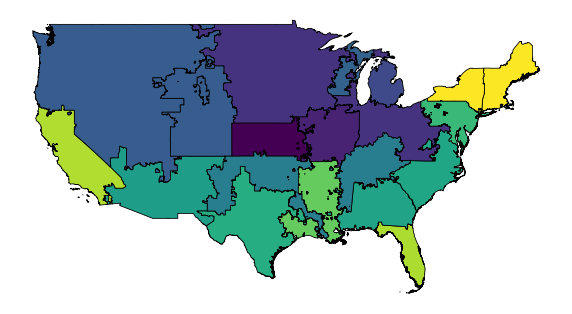

In [ ]:
ig, ax = plt.subplots(1, figsize=(10, 6))
v_compare = 'drone_emissions_km'
vmin = df[v_compare].min()
vmax = df[v_compare].max()
color = "viridis_r"
df_main.plot(column=v_compare, cmap= color, linewidth=0.8, ax=ax, edgecolor='0', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = [] #empty array for the data range
cbar = fig.colorbar(sm) #add the colorbar to the figure
cbar.ax.set_ylabel("gCO₂e/km", fontsize=16)
#ax.set_xlabel('Longitude (deg)')
#ax.set_ylabel('Latitude (deg)')
plt.tick_params(axis='both', which='both',bottom=False, left=False, 
                labelbottom=False, labelleft=False)
#ax.set_title("Drone emissions", fontsize=16)
sns.despine(top=True, right=True, bottom=True, left=True)
fig.savefig(v_compare + '.pdf')

In [ ]:
df.columns

Index(['region', 'Shape_Leng', 'Shape_Le_1', 'Shape_Area', 'geometry',
       'Medium duty truck', 'Small diesel van', 'Medium duty electric truck',
       'Small electric van', 'Electric cargo bicycle', 'Quad-copter drone',
       'drone_emissions', 'drone_emissions_km'],
      dtype='object')

In [ ]:
d = df.drone_emissions_km
print(d)
print(d.max(), d.min())
print((d.max()-d.min())/d.min())

0      9.706429
1     10.897402
2     10.012205
3      7.834209
4      9.580237
5      7.860905
6     11.070655
7     12.349718
8     11.588026
9     12.687147
10     7.099732
11    11.739301
12     7.604286
13     9.343559
14     7.061349
15     9.202616
16    12.173718
17    12.685116
18    11.721146
19    13.650818
20    10.885577
21     8.617282
22    13.028158
23     9.824738
24    10.886234
25     9.753311
26    11.828944
Name: drone_emissions_km, dtype: float64
13.650818236023333 7.06134884382596
0.9331743180991304


In [ ]:
df['Medium duty truck'].min(), df['Medium duty truck'].max()

(17.09128317189918, 33.040429691275335)

In [ ]:
df[['region', 'ghg_pack']].sort_values(by='drone_emissions_km')

KeyError: ignored

In [ ]:
emissions_vehicles_total = pd.merge(subregions, ghg_packs_to_drone, on='region', how='outer')